# *Importing Required tools*



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import warnings
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import time
import os
from math import sqrt
import copy
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from sklearn import metrics
warnings.filterwarnings("ignore")

# *Data transforms defined on train and test dataset*

In [3]:
# Transforms used to normalise the datasets and match the size with ImageNet dataset
data_transforms ={
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])      
    ])
    
}

# *Loading train and test data to a dictionary*

In [4]:
data_dir = '/content/drive/MyDrive/assignment1_data/classification_dataset'

#Taking the train and test data into the dictionary

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataset_sizes = {x :len(image_datasets[x]) for x in ['train', 'test']}

#Setting appropriate batchsize and shuffle for each dataset

shuffle = {'train': 'True', 'test': 'False'}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = dataset_sizes[x], shuffle = shuffle[x], num_workers = 2) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print('Train and Test dataset after saving in the dictionary\n')
print(dataset_sizes,'\n')
print('Class Names are as follows:\n')
print(class_names)

Train and Test dataset after saving in the dictionary

{'train': 532, 'test': 120} 

Class Names are as follows:

['bear', 'butterfly', 'camel', 'chimp', 'duck', 'elephant']


# *Device Information*

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.device_count()

1

In [7]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda:0


# *Using the pretrained ResNet18 Model to extract features*

In [9]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# *Extracting features before fully connected layer*

In [10]:
nodes, _ = get_graph_node_names(model)
print(nodes)

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.add', 'layer2.1.relu_1', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.0.add', 'layer3.0.relu_1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer3.1.add', 'layer3.1.relu_1', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'lay

In [11]:
return_nodes = {'flatten':'f'}
model = create_feature_extractor(model, return_nodes = return_nodes)

# *Extracting features of our train dataset*

In [12]:
#Model in evaluation mode with gradients freezed

model.eval()
with torch.no_grad():
  for inputs, labels in dataloaders['train']:
    inputs = inputs.to(device)
  features = model(inputs)['f'].cpu().numpy()
  train_labels = labels.numpy()
# print(features.shape)
# print(labels.shape)

# *Extracting features of out test dataset*

In [13]:
with torch.no_grad():
  for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
  outputs = model(inputs)['f'].cpu().numpy()
  test_labels = labels.numpy()
# print(outputs.shape)
# print(output_labels.shape)

# *Using kNN Classifier to predict the labels of test data*

In [17]:
#Using scikit learn library to apply kNN classifier

neigh = KNeighborsClassifier(n_neighbors = 50)
neigh.fit(features, train_labels) 
predictions = neigh.predict(outputs)
print('Predicted labels: \n \n', predictions, '\n')
print('Actual labels: \n \n', test_labels, '\n')

#Calculating the accuracy

true_label = []
pred_label = []
count = 0
for i in range(len(test_labels)):
  true_label.append(class_names[test_labels[i]])
  pred_label.append(class_names[predictions[i]])
  if test_labels[i] == predictions[i]:
    count = count + 1
print('Accuracy on test data is: ',count * 100 /len(test_labels))
print('\n\n\n\n                ###### CLASSIFICATION REPORT ###### \n\n')
print(metrics.classification_report(true_label, pred_label))
print("\n\n CONFUSION MATRIX\n\n")
print(metrics.confusion_matrix(true_label, pred_label))

Predicted labels: 
 
 [2 1 3 1 2 5 0 0 2 4 2 2 4 1 5 0 3 5 2 2 4 0 0 0 0 3 0 3 2 1 3 3 1 1 3 5 3
 5 0 0 0 1 0 4 0 5 2 4 2 1 1 3 4 3 1 0 1 2 1 1 4 4 2 3 3 0 4 5 2 5 1 1 4 1
 5 4 2 3 5 1 3 5 2 3 1 0 1 5 3 5 4 2 5 4 2 3 5 4 0 5 3 4 4 0 5 2 5 5 4 4 0
 0 0 1 2 4 5 2 3 3] 

Actual labels: 
 
 [2 1 3 1 2 5 0 0 2 4 2 2 4 1 5 0 3 5 2 2 4 0 0 0 0 3 0 3 2 1 3 3 1 1 3 5 3
 5 0 0 0 1 0 4 4 5 2 4 2 1 1 3 4 3 1 0 1 2 1 1 4 4 2 3 3 0 4 5 2 5 1 1 4 1
 5 4 2 3 5 1 3 5 2 3 1 0 1 5 3 5 4 2 5 4 2 3 5 4 0 5 3 4 4 0 5 2 5 5 4 4 0
 0 0 1 2 4 5 2 3 3] 

Accuracy on test data is:  99.16666666666667




                ###### CLASSIFICATION REPORT ###### 


              precision    recall  f1-score   support

        bear       0.95      1.00      0.98        20
   butterfly       1.00      1.00      1.00        20
       camel       1.00      1.00      1.00        20
       chimp       1.00      1.00      1.00        20
        duck       1.00      0.95      0.97        20
    elephant       1.00      1.00   

# *Plotting decision regions*

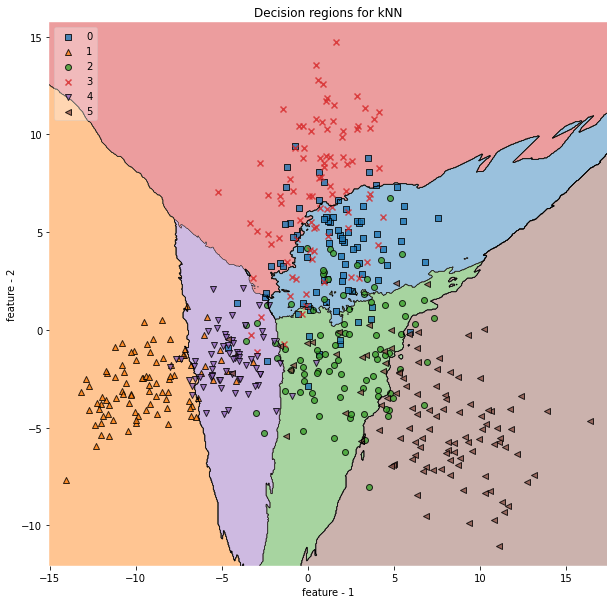

In [19]:
# Use PCA to reduce the dimensionality to 2

pca = PCA(n_components = 2)
features_reduced = pca.fit_transform(features)

#Using kNN Classifier again on reduced data

neigh = KNeighborsClassifier(n_neighbors = 50)
neigh.fit(features_reduced, train_labels) 

#plotting

fig = plt.figure(figsize=(10, 10))
plot_decision_regions(features_reduced, train_labels, clf = neigh, legend=2)
plt.xlabel('feature - 1')
plt.ylabel('feature - 2')
plt.title('Decision regions for kNN')
plt.show()